In [22]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [23]:
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
import pytesseract
import imutils
import cv2
import re
import requests
import numpy as np
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
from konlpy.tag import Okt

In [24]:
def plt_imshow(title='image',img=None, figsize=(8,5)):
    plt.figure(figsize=figsize)
    
    if type(img) == list :
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <=2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else :
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1,len(img), i +1),plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
        plt.show()
    
    else :
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        else :
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

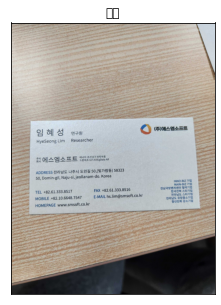

In [26]:
img2 = cv2.imread("name5.jpg", cv2.IMREAD_COLOR)
plt_imshow("명함",img2)

In [27]:
def make_scan_image(image,width,ksize=(5,5),min_threshold=75,max_threshold=200):
    image_list_title = []
    image_list = []
    
    org_image = image.copy()
    image = imutils.resize(image, width=width)
    ratio = org_image.shape[1] / float(image.shape[1])
    
    # 이미지를 grayscale로 변환하고 blur를 적용
    # 모서리르 ㄹ 찾기위한 이미지 연산
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, ksize, 0.5)
    edged = cv2.Canny(blurred, min_threshold, max_threshold)
    
    image_list_title = ['gray', 'blurred', 'edged']
    image_list = [gray, blurred, edged]
    
    # contours를 찾아 크기순으로 정렬
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    findCnt = None
    
    # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02*peri, True)
        
        # contours가 크기순으로 정렬되어 있기 때문에 제일 첫번째 사각형을 영역으로 판단하고 break
        if len(approx) ==4:
            findCnt = approx
            break
        
    
    if findCnt is None :
        raise Exception(("Could not find out line"))
    output = image.copy()
    cv2.drawContours(output, [findCnt], -1, (0,255,0),2)
    
    image_list_title.append("Outline")
    image_list.append(output)
    
    # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
    transform_image = four_point_transform(org_image, findCnt.reshape(4,2)*ratio)
    
    plt_imshow(image_list_title, image_list)
    plt_imshow("Transform",transform_image )
    
    return transform_image
    

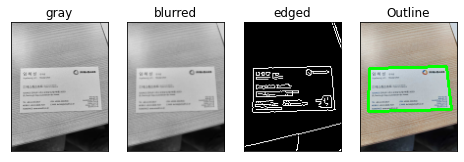

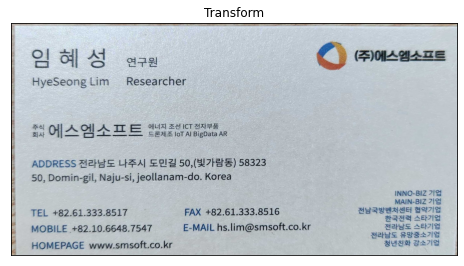

In [28]:
imgread = make_scan_image(img2,width=100, ksize=(5,5), min_threshold=50, max_threshold=100)

In [29]:
text8 =pytesseract.image_to_string(imgread,lang='eng+kor')
print(text8)

ek a Re a a ah ee PM Ree ee ee 7

임 혜 성 area

HyeSeong Lim Researcher

주식 A. oj 에너지 조선 ICT 전 자 부
에 aiid ail AL 프트 드 론 제 조 101 Al ce AR

ADDRESS 전라남도 나주시 도 민 길 50,( 빚 가 람 동) 58323
50, Domin-gil, Naju-si, jeollanam-do. Korea

TEL +82.61.333.8517 FAX +82.61.333.8516
MOBILE +82.10.6648.7547 E-MAIL hs.lim@smsoft.co.kr
HOMEPAGE www.smsoft.co.kr

INNO-BIZ 기업

MAIN-BIZ 7/2

전 남 국 방 벤 처 센터 협 약 기업
한 국 전 력 스 타 기업
전라남도 스 타 기업
전라남도 유 망 중소기업

청 년 천 화 강 소 기업

“마마



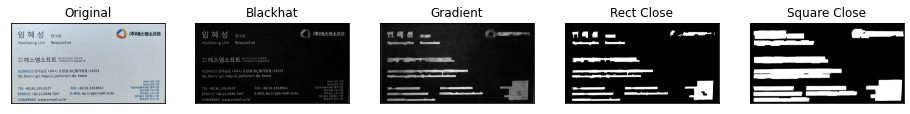

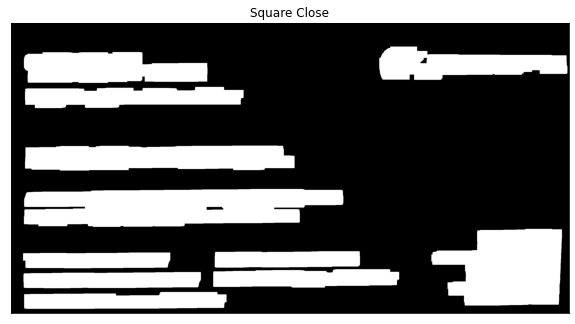

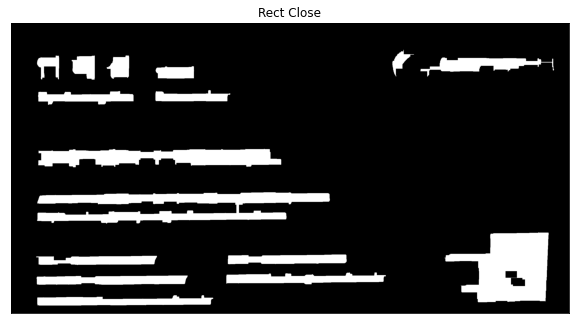

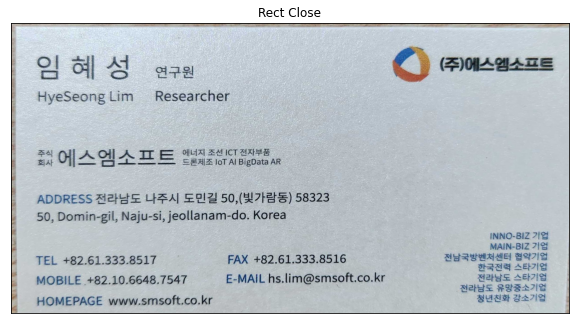

In [34]:
gray = cv2.cvtColor(imgread, cv2.COLOR_BGR2GRAY)
(H,W) = gray.shape

rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,30))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT,(130,35))

gray = cv2.GaussianBlur(gray, (11,11),0)
blackhat = cv2.morphologyEx(gray,cv2.MORPH_BLACKHAT, rectKernel)

grad = cv2.Sobel(blackhat, ddepth = cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")
 
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
close_thresh = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, sqKernel)
se = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3)) # 가로 5, 세로 3
close_thresh = cv2.erode(close_thresh, se, iterations=2)
 
plt_imshow(["Original", "Blackhat", "Gradient", "Rect Close", "Square Close"], [imgread, blackhat, grad, thresh, close_thresh], figsize=(16, 10))

plt_imshow(["Square Close"],[close_thresh], figsize=(10,6))
plt_imshow(["Rect Close"],[thresh], figsize=(10,6))
plt_imshow(["Rect Close"],[imgread], figsize=(10,6))

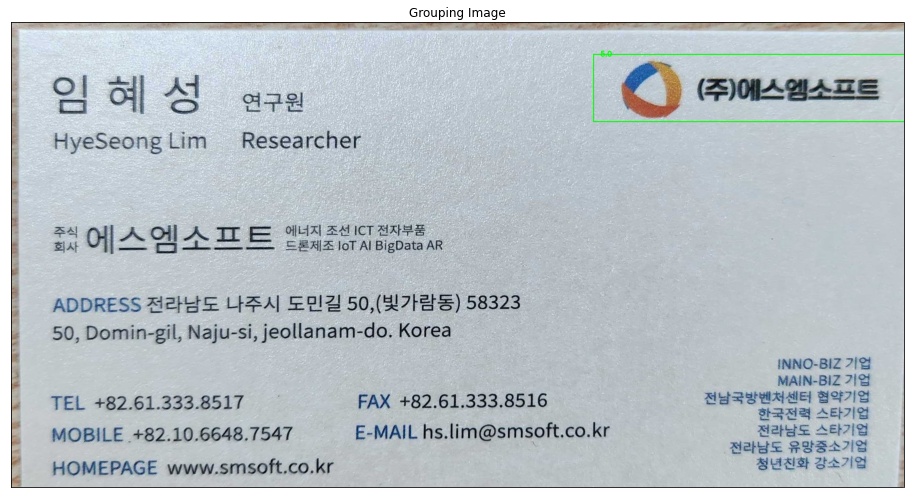

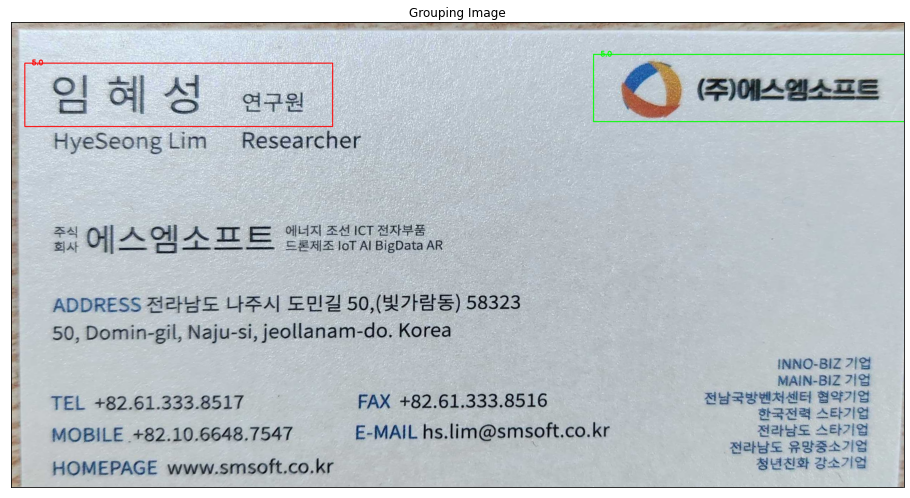

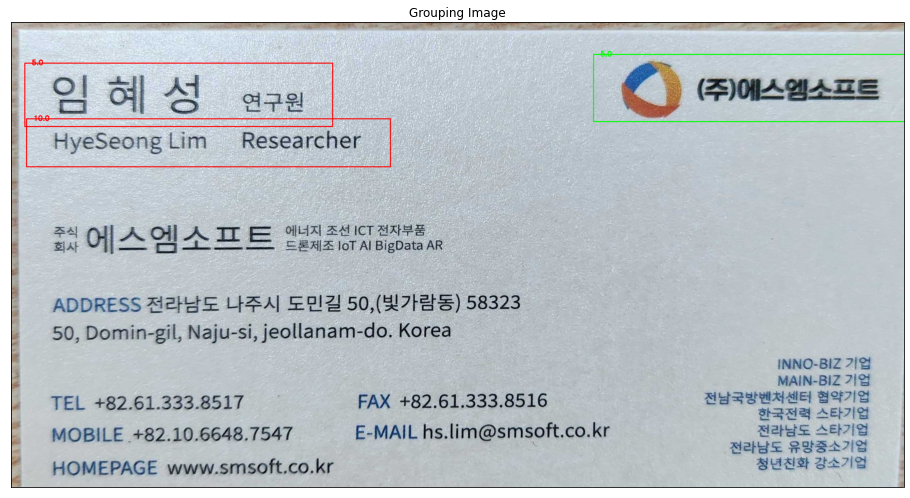

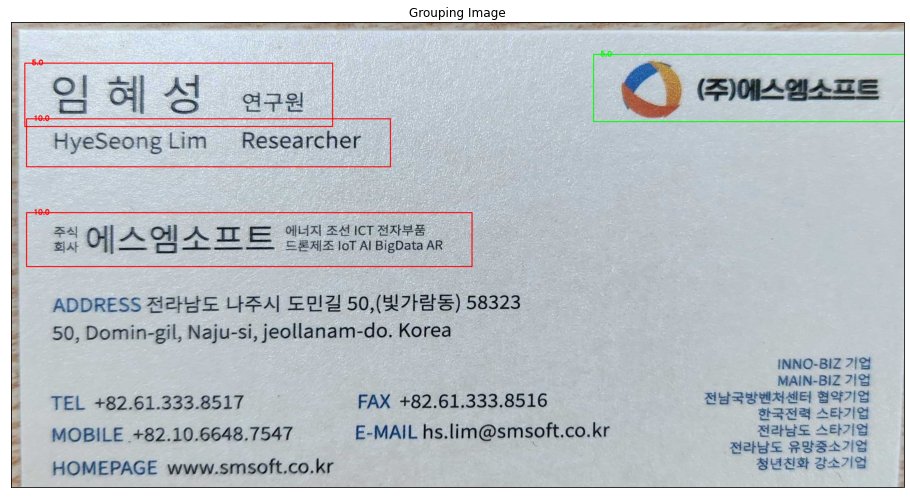

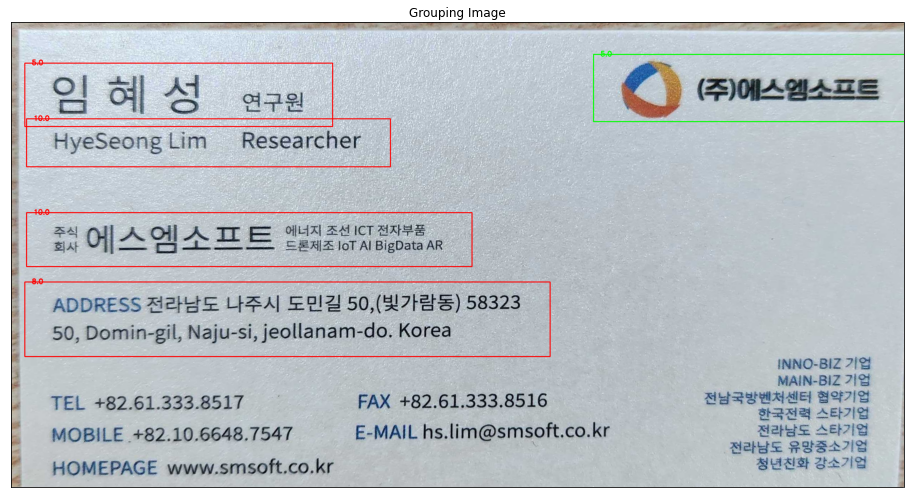

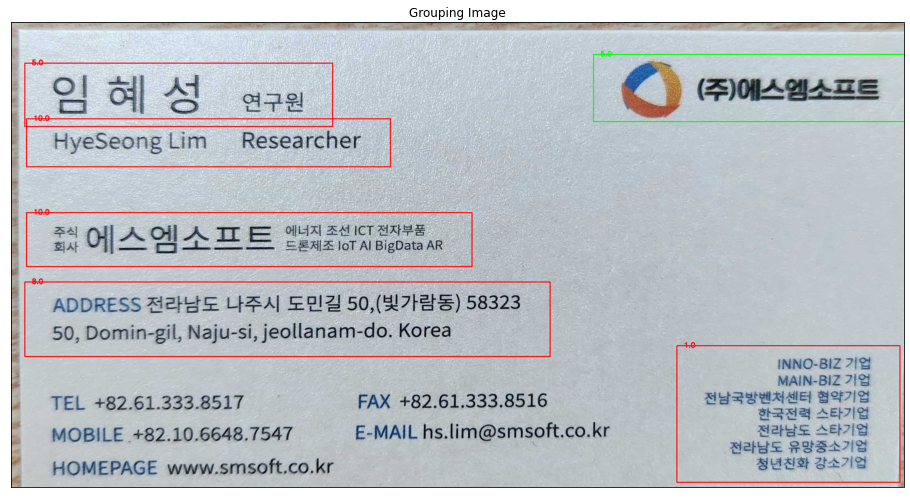

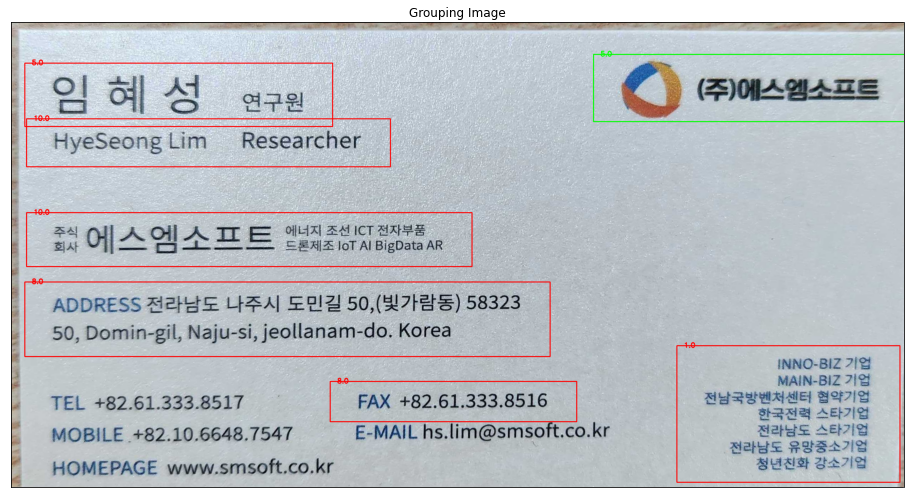

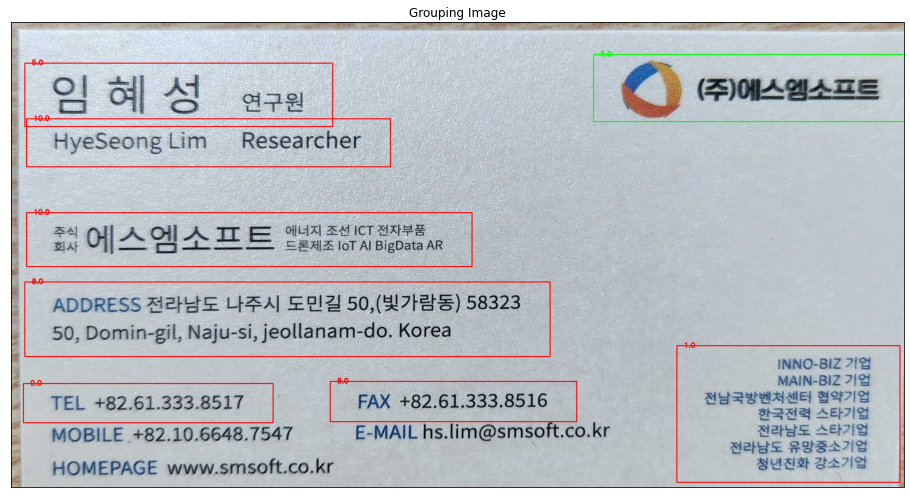

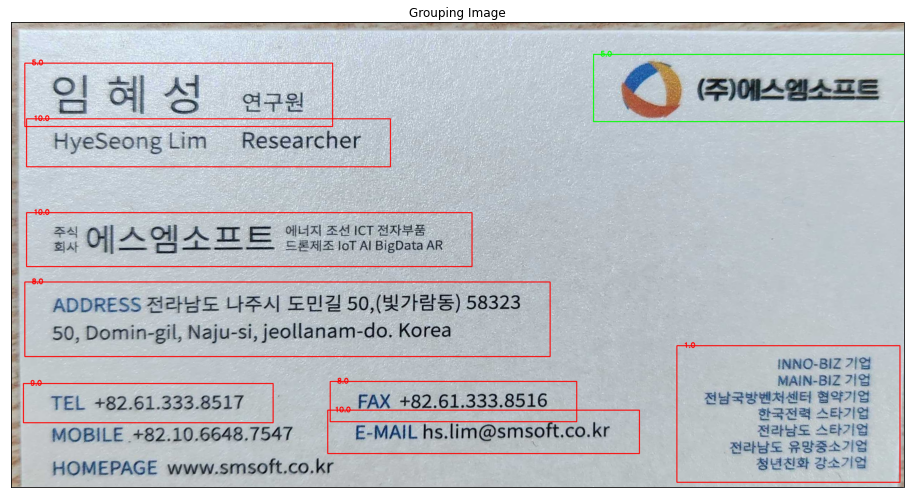

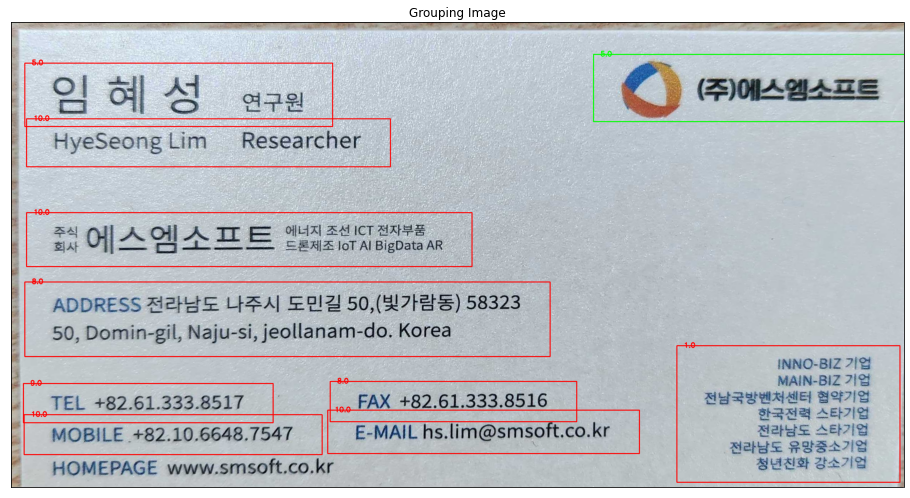

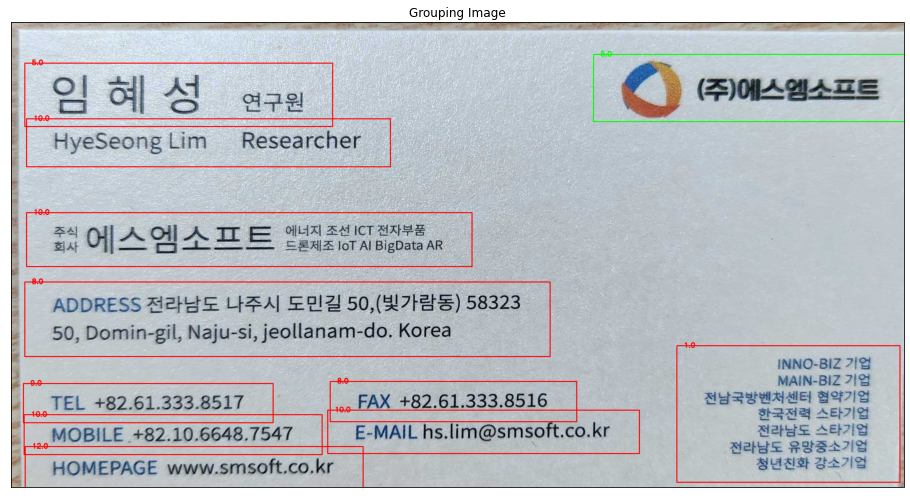

In [497]:
#nts = cv2.findContours(close_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cv2.findContours(close_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="top-to-bottom")[0]
 
roi_list = []
roi_title_list = []
 
margin = 20
receipt_grouping = imgread.copy()
 
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w // float(h)
 
    if ar > 4.5 and ar < 30.5 and (W/2) < x:
        color = (0, 255, 0)
        roi = imgread[y - margin:y + h + margin, x - margin:x + w + margin]
        roi_list.append(roi)
        roi_title_list.append("Roi_{}".format(len(roi_list)))
    else:
        color = (0, 0, 255)
        roi = imgread[y - margin:y + h + margin, x - margin:x + w + margin]
        roi_list.append(roi)
        roi_title_list.append("Roi_{}".format(len(roi_list)))
 
    cv2.rectangle(receipt_grouping, (x - margin, y - margin), (x + w + margin, y + h + margin), color, 2)
    cv2.putText(receipt_grouping, "".join(str(ar)), (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.65, color, 2)
  
    plt_imshow(["Grouping Image"], [receipt_grouping], figsize=(16, 10))

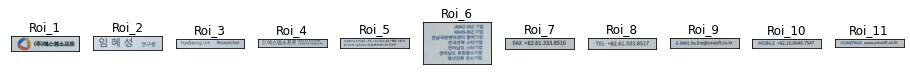

 > (주)에스앰소프트

of

연구

임혜성

HyeSeong Lim Researcher

에너지 조선 ICT MASS
드론제조 1071 BigData AR

ADDRESS 전라남도 나주시 도민길 50,(빚가람동) 58323
50, Domin-gil, Naju-si, jeollanam-do. Korea

INNO-BIZ 기업

MAIN-BIZ 기업

전남국방벤처센터 형약기업
한국전력 스타기업
전라남도 스타기업
전라남도 유망중소기업
MAS 강소기업

FAX +82.61.333.8516

TEL +82.61.333.8517

E-MAIL hs.lim@smsoft.co.kr

MOBILE +82.10.6648.7547

HOMEPAGE www.smsoft.co.kr



In [498]:
plt_imshow(roi_title_list, roi_list, figsize=(16, 10))
#추가
roi_textlist=[]
for roi in roi_list:
    gray_roi= cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    threshold_roi = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    roi_text = pytesseract.image_to_string(threshold_roi ,lang='kor+eng')
    roi_textlist.append(roi_text)
    print(roi_text)

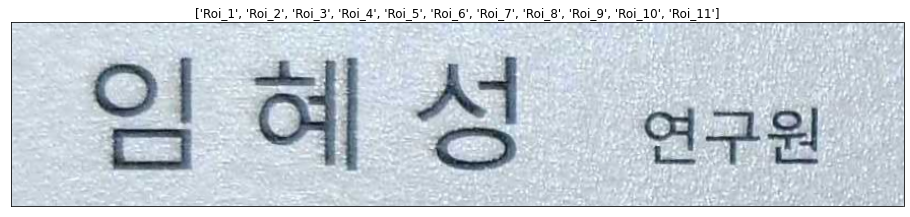

[' > (주)에스앰소프트\n', 'of\n\n연구\n\n임혜성\n', 'HyeSeong Lim Researcher\n', '에너지 조선 ICT MASS\n드론제조 1071 BigData AR\n', 'ADDRESS 전라남도 나주시 도민길 50,(빚가람동) 58323\n50, Domin-gil, Naju-si, jeollanam-do. Korea\n', 'INNO-BIZ 기업\n\nMAIN-BIZ 기업\n\n전남국방벤처센터 형약기업\n한국전력 스타기업\n전라남도 스타기업\n전라남도 유망중소기업\nMAS 강소기업\n', 'FAX +82.61.333.8516\n', 'TEL +82.61.333.8517\n', 'E-MAIL hs.lim@smsoft.co.kr\n', 'MOBILE +82.10.6648.7547\n', 'HOMEPAGE www.smsoft.co.kr\n']


In [499]:
plt_imshow(roi_title_list, roi_list[1], figsize=(16, 10))
# text1=pytesseract.image_to_string(roi_title_list, roi_list[1],lang='kor+eng')
# print(text1)-
#이름

#plt_imshow(roi_title_list, roi_list[12], figsize=(16, 10))
# text2=pytesseract.image_to_string(roi_title_list, roi_list[12],lang='kor+eng')
# print(text2)
#번호

print(roi_textlist)



In [500]:
# def reorderPTs(pts):
#     idx = np.lexsort((pts[:.1], pts[:,0]))
    
#     if pts[0,1]>pts[1,1]:
#         pts[[0,1]] = pts[[1,0]]
        
#     if pts[2,1] < pts[3,1]:
#         ots[[2,3]] = pts[[3,2]]
    
#     return pts




In [501]:
def mergeResize(img, row=300, col=200):
    IMG_COL = col #66

    # row값에 따른 col값 변경
    IMG_COL = int((row * IMG_COL)/row)

    IMG_ROW = row
    border_v = 0
    border_h = 0

    if (IMG_COL / IMG_ROW) >= (img.shape[0] / img.shape[1]):
        border_v = int((((IMG_COL / IMG_ROW) * img.shape[1]) - img.shape[0]) / 2)
    else:
        border_h = int((((IMG_ROW / IMG_COL) * img.shape[0]) - img.shape[1]) / 2)
    img = cv2.copyMakeBorder(img, top=border_v, bottom=border_v, left=0, right=border_h + border_h, borderType=cv2.BORDER_CONSTANT, value=(255, 255, 255))
    img = cv2.resize(img, (IMG_ROW, IMG_COL))
    return img

In [502]:
for idx, roi in enumerate(roi_list):
  if idx == 0:
    mergeImg = mergeResize(roi)
  else:
    cropImg = mergeResize(roi)
    mergeImg = np.concatenate((mergeImg, cropImg), axis=0)

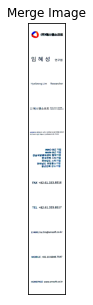

HyeSeong Lim Researcher

HOAMADE TAiisomn

ADDRESS 전라남도 나주시 도민길 50,(빛가람동) 58323
50, Domin-gil, Naju-si, jeollanam-do. Korea

INNO-BIZ 기업

MAIN-BIZ 기업

전남국방벤처센터 협약기업
한국전력 스타기업
전라남도 스타기업
전라남도 유망중소기업
청년친화 강소기엉

FAX +82.61.333.8516

TEL +82.61.333.8517

E-MAIL hs.lim@smsoft.co.kr

MOBILE .+82.10.6648.7547

HOMEPAGE www.smsoft.co.kr

HOMEPAGE www.smsoft.co.kr



In [503]:
#threshold_mergeImg = cv2.threshold(mergeImg, 150, 255, cv2.THRESH_BINARY)[1]
threshold_mergeImg = cv2.threshold(mergeImg, 150, 255, cv2.THRESH_BINARY)[1]
plt_imshow(["Merge Image"], [threshold_mergeImg])

merge_Img_text = pytesseract.image_to_string(threshold_mergeImg,lang='kor+eng')
print(merge_Img_text)



gray_roi= cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
threshold_roi = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
roi_text = pytesseract.image_to_string(threshold_roi ,lang='kor+eng')
print(roi_text)

In [504]:
options = "--psm 4"
text = pytesseract.image_to_string(threshold_mergeImg,lang='kor+eng')

# OCR결과 출력
print("[INFO] OCR결과:")
print("==================")
print(text)
print("\n")

[INFO] OCR결과:
HyeSeong Lim Researcher

HOAMADE TAiisomn

ADDRESS 전라남도 나주시 도민길 50,(빛가람동) 58323
50, Domin-gil, Naju-si, jeollanam-do. Korea

INNO-BIZ 기업

MAIN-BIZ 기업

전남국방벤처센터 협약기업
한국전력 스타기업
전라남도 스타기업
전라남도 유망중소기업
청년친화 강소기엉

FAX +82.61.333.8516

TEL +82.61.333.8517

E-MAIL hs.lim@smsoft.co.kr

MOBILE .+82.10.6648.7547

HOMEPAGE www.smsoft.co.kr



